In [1]:
import torch
from torch import nn
from torch.distributions import Normal
from abc import ABC, abstractmethod
import numpy as np
from time import time
from datetime import timedelta
import matplotlib.pyplot as plt
# matplotlibをnotebookで描画するためのコマンド．
%matplotlib inline

In [2]:
!nvidia-smi

Mon Sep 14 02:15:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 950M    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   75C    P0    N/A /  N/A |    530MiB /  2004MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.__version__

'1.6.0+cu101'

In [5]:
from rex_gym.envs.gym.gallop_env import RexReactiveEnv

In [6]:
# env = RexReactiveEnv(terrain_id='mounts', terrain_type='png', render=True)
# env = RexReactiveEnv(terrain_id='hills', terrain_type='csv', render=True)
env = RexReactiveEnv(terrain_id='plane', terrain_type='random', render=True)
env.reset()

reset
reset
reset


/home/ken/.local/share/virtualenvs/env-KSxiTnGN/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([-0.01120414, -0.02117952,  0.00483729,  0.01796641, -0.07631158,
       -0.91086726,  1.34631204,  0.0472513 , -0.93400384,  1.33731786,
        0.01247665, -0.87609415,  1.33471505,  0.01371606, -0.9166647 ,
        1.3086133 ])

In [21]:
env.reset()
done = False

# 終了シグナル(done=True)が返ってくるまで，ランダムに環境を動かす．
while (not done):
  action = env.action_space.sample()
  _, _, done, _ = env.step(action)


reset
OUT OF TRAJECTORY!


In [11]:
del env

In [5]:
from rex_gym.envs.gym.walk_env import RexWalkEnv

In [6]:
env = RexWalkEnv(terrain_id='plane', terrain_type='random', render=True)
env.reset()

reset
reset
reset


/home/ken/.local/share/virtualenvs/env-KSxiTnGN/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([-0.01120026, -0.02116809,  0.00481351,  0.0178849 ])

In [8]:
env.reset()
done = False

# 終了シグナル(done=True)が返ってくるまで，ランダムに環境を動かす．
while (not done):
  action = env.action_space.sample()
  _, _, done, _ = env.step(action)


reset


KeyboardInterrupt: 

In [ ]:
del env

In [6]:
class Trainer:

    def __init__(self, env, env_test, algo, seed=0, num_steps=10**6, eval_interval=10**4, num_eval_episodes=3):

        self.env = env
        self.env_test = env_test
        self.algo = algo

        # 環境の乱数シードを設定する．
        self.env.seed(seed)
        self.env_test.seed(2**31-seed)

        # 平均収益を保存するための辞書．
        self.returns = {'step': [], 'return': []}

        # データ収集を行うステップ数．
        self.num_steps = num_steps
        # 評価の間のステップ数(インターバル)．
        self.eval_interval = eval_interval
        # 評価を行うエピソード数．
        self.num_eval_episodes = num_eval_episodes

    def train(self):
        """ num_stepsステップの間，データ収集・学習・評価を繰り返す． """

        # 学習開始の時間
        self.start_time = time()
        # エピソードのステップ数．
        t = 0

        # 環境を初期化する．
        state = self.env.reset()

        for steps in range(1, self.num_steps + 1):
            # 環境(self.env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            # アルゴリズムに渡し，状態・エピソードのステップ数を更新する．
            state, t = self.algo.step(self.env, state, t, steps)

            # アルゴリズムが準備できていれば，1回学習を行う．
            if self.algo.is_update(steps):
                self.algo.update()

            # 一定のインターバルで評価する．
            if steps % self.eval_interval == 0:
                self.evaluate(steps)

    def evaluate(self, steps):
        """ 複数エピソード環境を動かし，平均収益を記録する． """

        returns = []
        for _ in range(self.num_eval_episodes):
            state = self.env_test.reset()
            done = False
            episode_return = 0.0

            while (not done):
                action = self.algo.exploit(state)
                state, reward, done, _ = self.env_test.step(action)
                episode_return += reward

            returns.append(episode_return)

        mean_return = np.mean(returns)
        self.returns['step'].append(steps)
        self.returns['return'].append(mean_return)

        print(f'Num steps: {steps:<6}   '
              f'Return: {mean_return:<5.1f}   '
              f'Time: {self.time}')

    def visualize(self, env):
        """ 1エピソード環境を動かし，mp4を再生する． """
#         env = wrap_monitor(gym.make(self.env.unwrapped.spec.id))
        state = env.reset()
        done = False

        while (not done):
            action = self.algo.exploit(state)
            state, _, done, _ = env.step(action)

#         del env
#         return play_mp4()
        return

    def plot(self):
        """ 平均収益のグラフを描画する． """
        fig = plt.figure(figsize=(8, 6))
        plt.plot(self.returns['step'], self.returns['return'])
        plt.xlabel('Steps', fontsize=24)
        plt.ylabel('Return', fontsize=24)
        plt.tick_params(labelsize=18)
#         plt.title(f'{self.env.unwrapped.spec.id}', fontsize=24)
        plt.tight_layout()

    @property
    def time(self):
        """ 学習開始からの経過時間． """
        return str(timedelta(seconds=int(time() - self.start_time)))

In [7]:
class Algorithm(ABC):

    def explore(self, state):
        """ 確率論的な行動と，その行動の確率密度の対数 \log(\pi(a|s)) を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action, log_pi = self.actor.sample(state)
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        """ 決定論的な行動を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action = self.actor(state)
        return action.cpu().numpy()[0]

    @abstractmethod
    def is_update(self, steps):
        """ 現在のトータルのステップ数(steps)を受け取り，アルゴリズムを学習するか否かを返す． """
        pass

    @abstractmethod
    def step(self, env, state, t, steps):
        """ 環境(env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            受け取り，リプレイバッファへの保存などの処理を行い，状態・エピソードのステップ数を更新する．
        """
        pass

    @abstractmethod
    def update(self):
        """ 1回分の学習を行う． """
        pass

In [8]:
def calculate_log_pi(log_stds, noises, actions):
    """ 確率論的な行動の確率密度を返す． """

    # NOTE: 入力はすべて (batch_size, |A|) となっているので，この関数では　batch_size　分の確率密度の対数 \log \pi(a|s) を
    # それぞれ独立に計算し (batch_size, 1) で返します．

    # ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|a))を計算する．
    stds = log_stds.exp()
    gaussian_log_probs = Normal(torch.zeros_like(stds), stds).log_prob(stds * noises).sum(dim=-1, keepdim=True)

    # NOTE: gaussian_log_probs には (batch_size, 1) で表された確率密度の対数 \log p(u|s) が入っています．

    # [演習] その後，tanh による確率密度の変化を修正しましょう．
    # (例)
    # log_pis = gaussian_log_probs - ...
    log_pis = gaussian_log_probs - torch.log(1 - actions.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
    
    return log_pis

In [9]:
def reparameterize(means, log_stds):
    """ Reparameterization Trickを用いて，確率論的な行動とその確率密度を返す． """

    # 標準偏差．
    stds = log_stds.exp()

    # [演習] Reparameterization Trickを用いて，標準ガウス分布からノイズをサンプリングし，確率論的な行動を計算しましょう．
    # (例)
    # noises = ...
    # actions = ...
    noises = torch.randn_like(means)
    us = means + noises * stds
    actions = torch.tanh(us)

    # 確率論的な行動の確率密度の対数を計算する．
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis

In [10]:
class SACActor(nn.Module):
    
    def __init__(self, state_shape, action_shape):
        super().__init__()

        # 状態を受け取り，ガウス分布の平均と標準偏差の対数を出力するネットワークを構築します．
        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2 * action_shape[0]),
        )

    def forward(self, states):
        # [演習] 決定論的な行動を計算し，返します．
        # return ...
        return torch.tanh(self.net(states).chunk(2, dim=-1)[0])

    def sample(self, states):
        # [演習] 確率論的な行動と確率密度の対数を計算し，返します．
        # means, log_stds = ...
        # log_stds.clamp_(-20, 2)
        # return ...
        means, log_stds = self.net(states).chunk(2, dim=-1)
        return reparameterize(means, log_stds.clamp_(-20, 2))

In [11]:
class SACCritic(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        # 状態を受け取り，ソフト状態行動価値を出力するネットワークを2つ構築します．
        self.net1 = nn.Sequential(
            nn.Linear(state_shape[0] + action_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )
        self.net2 = nn.Sequential(
            nn.Linear(state_shape[0] + action_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, states, actions):
        # [演習] ソフト状態行動価値を2つ計算し，返します．
        # return ...
        x = torch.cat([states, actions], dim=-1)
        return self.net1(x), self.net2(x)

In [12]:
class ReplayBuffer:

    def __init__(self, buffer_size, state_shape, action_shape, device):
        # 次にデータを挿入するインデックス．
        self._p = 0
        # データ数．
        self._n = 0
        # リプレイバッファのサイズ．
        self.buffer_size = buffer_size

        # GPU上に保存するデータ．
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.next_states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)

    def append(self, state, action, reward, done, next_state):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.next_states[self._p].copy_(torch.from_numpy(next_state))

        self._p = (self._p + 1) % self.buffer_size
        self._n = min(self._n + 1, self.buffer_size)

    def sample(self, batch_size):
        idxes = np.random.randint(low=0, high=self._n, size=batch_size)
        return (
            self.states[idxes],
            self.actions[idxes],
            self.rewards[idxes],
            self.dones[idxes],
            self.next_states[idxes]
        )

In [13]:
class SAC(Algorithm):

    def __init__(self, state_shape, action_shape, device=torch.device('cuda'), seed=0,
                 batch_size=256, gamma=0.99, lr_actor=3e-4, lr_critic=3e-4,
                 replay_size=10**6, start_steps=10**4, tau=5e-3, alpha=0.2, reward_scale=1.0):
        super().__init__()

        # シードを設定する．
        np.random.seed(seed)
        torch.manual_seed(seed)

        # リプレイバッファ．
        self.buffer = ReplayBuffer(
            buffer_size=replay_size,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device,
        )

        # Actor-Criticのネットワークを構築する．
        self.actor = SACActor(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device)
        self.critic = SACCritic(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device)
        self.critic_target = SACCritic(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device).eval()

        # ターゲットネットワークの重みを初期化し，勾配計算を無効にする．
        self.critic_target.load_state_dict(self.critic.state_dict())
        for param in self.critic_target.parameters():
            param.requires_grad = False

        # オプティマイザ．
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        # その他パラメータ．
        self.learning_steps = 0
        self.batch_size = batch_size
        self.device = device
        self.gamma = gamma
        self.start_steps = start_steps
        self.tau = tau
        self.alpha = alpha
        self.reward_scale = reward_scale

    def is_update(self, steps):
        # 学習初期の一定期間(start_steps)は学習しない．
        return steps >= max(self.start_steps, self.batch_size)

    def step(self, env, state, t, steps):
        t += 1

        # 学習初期の一定期間(start_steps)は，ランダムに行動して多様なデータの収集を促進する．
        if steps <= self.start_steps:
            action = env.action_space.sample()
        else:
            action, _ = self.explore(state)
        next_state, reward, done, _ = env.step(action)

        # ゲームオーバーではなく，最大ステップ数に到達したことでエピソードが終了した場合は，
        # 本来であればその先もMDPが継続するはず．よって，終了シグナルをFalseにする．
        if t == 200:
            done_masked = False
            done=True
        else:
            done_masked = done
        

        # リプレイバッファにデータを追加する．
        self.buffer.append(state, action, reward, done_masked, next_state)

        # エピソードが終了した場合には，環境をリセットする．
        if done:
            t = 0
            next_state = env.reset()

        return next_state, t

    def update(self):
        self.learning_steps += 1
        states, actions, rewards, dones, next_states = self.buffer.sample(self.batch_size)

        self.update_critic(states, actions, rewards, dones, next_states)
        self.update_actor(states)
        self.update_target()

    def update_critic(self, states, actions, rewards, dones, next_states):
        # [演習] 現在のソフト状態行動価値とそのターゲットを計算し，ネットワークの損失関数を完成させましょう．
        # (例)
        # 現在のソフト状態行動価値を計算する．
        # curr_qs1, curr_qs2 = ...
        curr_qs1, curr_qs2 = self.critic(states, actions)

        with torch.no_grad():
              # ソフト状態価値のターゲットを計算します．
              # target_vs = ...
            next_actions, log_pis = self.actor.sample(next_states)
            next_qs1, next_qs2 = self.critic_target(next_states, next_actions)
            next_qs = torch.min(next_qs1, next_qs2) - self.alpha * log_pis

        # ソフト状態行動価値のターゲットを計算します．
        # target_qs = ...
        target_qs = rewards * self.reward_scale + (1.0 - dones) * self.gamma * next_qs

        loss_critic1 = (curr_qs1 - target_qs).pow_(2).mean()
        loss_critic2 = (curr_qs2 - target_qs).pow_(2).mean()

        self.optim_critic.zero_grad()
        (loss_critic1 + loss_critic2).backward(retain_graph=False)
        self.optim_critic.step()

    def update_actor(self, states):
        # [演習] 方策のネットワークの損失関数を計算しましょう．
        # (例)
        # loss_actor = ... self.actor ...
        actions, log_pis = self.actor.sample(states)
        qs1, qs2 = self.critic(states, actions)
        loss_actor = (self.alpha * log_pis - torch.min(qs1, qs2)).mean()

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        self.optim_actor.step()

    def update_target(self):
        for t, s in zip(self.critic_target.parameters(), self.critic.parameters()):
            t.data.mul_(1.0 - self.tau)
            t.data.add_(self.tau * s.data)

In [14]:

SEED = 0
REWARD_SCALE = 50.0

NUM_STEPS = 10 ** 6
EVAL_INTERVAL = 10 ** 4

env = RexReactiveEnv(terrain_id='plane', terrain_type='random', render=False)
env_test = RexReactiveEnv(terrain_id='plane', terrain_type='random', render=False)

algo = SAC(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    reward_scale=REWARD_SCALE
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)

reset
reset
reset


/home/ken/.local/share/virtualenvs/env-KSxiTnGN/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


reset


In [15]:
trainer.train()

reset
reset
FALLING DOWN!
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
reset
reset
reset
reset
reset
FALLING DOWN!
reset
reset
FALLING DOWN!
reset
reset
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
reset
reset
FALLING DOWN!
reset
reset
reset
reset
reset
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
FALLING DOWN!
reset
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
reset
reset
reset
FALLING DOWN!
reset
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
reset
FALLING DOWN!
reset
FALLING DOWN!
reset
FALLING DOWN!
Num st

KeyboardInterrupt: 

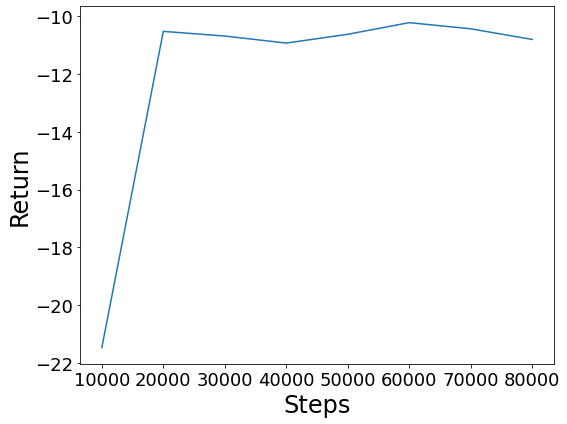

In [16]:
trainer.plot()

In [21]:

env_visualize = RexReactiveEnv(terrain_id='plane', terrain_type='random', render=True)


error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

In [ ]:
trainer.visualize(env_visualize)

reset


In [19]:
del env
del env_test
del env_visualize
del algo
del trainer

In [ ]:

SEED = 0
REWARD_SCALE = 50.0

NUM_STEPS = 10 ** 6
EVAL_INTERVAL = 10 ** 4

env = RexWalkEnv(terrain_id='plane', terrain_type='random', render=False)
env_test = RexWalkEnv(terrain_id='plane', terrain_type='random', render=False)

algo = SAC(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    reward_scale=REWARD_SCALE
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)

In [ ]:
trainer.train()

In [ ]:
trainer.plot()

In [ ]:

env_visualize = RexReactiveEnv(terrain_id='plane', terrain_type='random', render=True)

In [ ]:
trainer.visualize(env_visualize)

In [ ]:
del env
del env_test
del env_visualize
del algo
del trainer